# Модель 1
Создание новых фичей.
Создание реш деревьев, замер качества.

In [1]:
import pandas as pd
df = pd.read_csv('Объединенный датасет.csv')
df.head()

,path,avg_volume,last_volume,RSI,Close_price,low_BB,label
0,flet\рисунок1.png,7966.866085,12490.51852,48.144366,198.93,194.110330,0
1,flet\рисунок2.png,7945.199761,8316.19098,44.383995,197.69,194.184096,0
2,flet\рисунок3.png,7943.405529,3491.19392,47.226944,198.45,194.224070,0
3,flet\рисунок4.png,7937.281092,6059.82812,51.750965,199.63,194.207263,0
4,flet\рисунок6.png,4252.434634,13097.24441,33.383814,222.15,219.711943,0


In [7]:
(198.93 - 194.110330)/ 194.110330

0.02482953895343953

# Создание новых фичей

In [10]:
# 1. Бинаризация: выше или ниже Close_price
df["close_hier_low_BB"] = (df["Close_price"] > df["low_BB"]).astype(int)

# 2. Относительный объём: во сколько раз last_volume больше среднего (в процентах)
df["volume_diff_pct"] = ((df["last_volume"] - df["avg_volume"]) / df["avg_volume"] * 100).round(2)

# 3. Показатель в % на сколько высоко цена закрылась выше нижней полоски 
df["price_diff_pct"] = ((df["Close_price"] - df["low_BB"]) / df["Close_price"] * 100).round(2)

new_df = df[['RSI', 'close_hier_low_BB', 'volume_diff_pct', 'price_diff_pct', 'label']].copy()

new_df.head()

,RSI,close_hier_low_BB,volume_diff_pct,price_diff_pct,label
0,48.144366,1,56.78,2.42,0
1,44.383995,1,4.67,1.77,0
2,47.226944,1,-56.05,2.13,0
3,51.750965,1,-23.65,2.72,0
4,33.383814,1,207.99,1.10,0


# Модель 

In [9]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [13]:

y = new_df['label']
X = new_df.drop('label', axis=1)

# Разделение
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

# Обучение модели
model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=3, verbose=False, random_state=42)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.95      0.95       177
           1       0.93      0.93      0.93       122

    accuracy                           0.94       299
   macro avg       0.94      0.94      0.94       299
weighted avg       0.94      0.94      0.94       299



Краткое описание метрик:
precision (точность) — сколько из предсказанных положительных классов действительно верны.

recall (полнота) — сколько из реальных положительных классов были правильно найдены.

f1-score — гармоническое среднее между точностью и полнотой. Чем ближе к 1, тем лучше.

support — количество объектов в каждом классе.

📈 Интерпретация по классам:
Класс 0 (label=0):
Precision: 0.95 — из всех предсказанных "нулей", 95% действительно были нулями.

Recall: 0.95 — модель нашла 95% всех настоящих нулей.

F1-score: 0.95 — высокая сбалансированность между precision и recall.

Support: 177 — 177 объектов с меткой 0 в тесте.

Класс 1 (label=1):
Precision: 0.93, Recall: 0.93, F1-score: 0.93 — также очень хорошие показатели, но чуть ниже, чем у класса 0.

Support: 122 — меньше примеров, но модель справилась хорошо.

🧮 Общая оценка:
Accuracy: 0.94 — модель правильно классифицировала 94% всех примеров.

Macro avg: 0.94 — среднее значение по классам без учёта их количества.

Weighted avg: 0.94 — среднее значение с учётом того, сколько примеров в каждом классе.

✅ Вывод:
Модель хорошо сбалансирована, не перекошена в сторону одного класса, и работает стабильно на обоих классах. Это особенно хорошо, если классы несбалансированы (122 vs 177), но результат всё равно ровный.

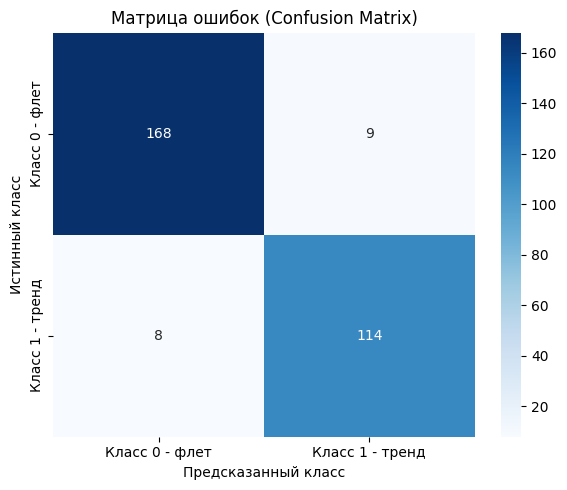

In [ ]:
# Повтор: исправим количество элементов, чтобы y_true и y_pred совпадали по длине
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Построение confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ["Класс 0 - флет", "Класс 1 - тренд"]

# Визуализация
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.title("Матрица ошибок (Confusion Matrix)")
plt.tight_layout()
plt.show()


In [16]:
model.save_model("Model1_trend_flet.cbm")
